# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle('/content/base_nfp.pkl')
df.head()
data_referencia = pd.to_datetime('2020-01-01')
df = df.query("`Data Emissão` > @data_referencia").copy()
df['evento'] = df['Retorno'] > 0

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
df['Dia da semana'] = df['Data Registro'].dt.dayofweek
df['Dia da semana'] = df['Dia da semana'].astype('category')
df['Fim de semana'] = df['Data Registro'].dt.dayofweek >=5
df['Dia do mês'] = df['Data Registro'].dt.day
df['Dia do mês'] = df['Dia do mês'].astype('category')
df['Mês'] = df['Data Registro'].dt.month
df['Mês'] = df['Mês'].astype('category')
df['Trimestre'] = df['Data Registro'].dt.quarter
df['Trimestre'] = df['Trimestre'].astype('category')
df['Valor NF 5'] = pd.qcut(df['Valor NF'], 5)
df['Valor NF 10'] = pd.qcut(df['Valor NF'], 10)
df['Valor NF 20'] = pd.qcut(df['Valor NF'], 20)
df['Valor NF 50'] = pd.qcut(df['Valor NF'], 50)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86932 entries, 100702 to 187645
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CNPJ emit.           86932 non-null  object        
 1   Emitente             86932 non-null  object        
 2   No.                  86932 non-null  int64         
 3   Data Emissão         86932 non-null  datetime64[ns]
 4   Valor NF             86932 non-null  float64       
 5   Data Registro        86932 non-null  datetime64[ns]
 6   Créditos             86932 non-null  float64       
 7   Situação do Crédito  86932 non-null  category      
 8   Ano                  86932 non-null  int64         
 9   Semestre             86932 non-null  int64         
 10  Retorno              85976 non-null  float64       
 11  flag_credito         86932 non-null  int64         
 12  categoria            86932 non-null  object        
 13  evento               86932 non

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [4]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [5]:
variaveis = ['Dia da semana', 'Fim de semana', 'Dia do mês', 'Mês', 'Trimestre', 'Valor NF 5', 'Valor NF 10', 'Valor NF 20', 'Valor NF 50']
df_iv = pd.DataFrame()
for var in variaveis:
    df_iv.loc[var, 'IV'] = IV(df[var], df.evento)

def colorir(val):
    cor = 'white'
    if val <= 0.02:
        cor = 'gray'
    elif val <= 0.1:
        cor = 'yellow'
    elif val <= 0.3:
        cor = 'cyan'
    elif val <= 0.5:
        cor = 'green'
    elif val > 0.5:
        cor = 'orange'
    return f'background-color: {cor}'

df_iv.style.applymap(colorir)

<ipython-input-5-b65cd9739e77>:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_iv.style.applymap(colorir)


,IV
Dia da semana,0.003935
Fim de semana,0.003113
Dia do mês,0.013810
Mês,0.009203
Trimestre,0.003453
Valor NF 5,0.039076
Valor NF 10,0.059165
Valor NF 20,0.078437
Valor NF 50,0.122413


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
  - As variáveis com maior valor de IV (Information Value) são "Valor NF 50" (0.122413) e "Valor NF 20" (0.078437), seguidas por "Valor NF 10" e "Valor NF 5".

- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?
  - Sim, parece haver uma relação. A medida que o número de categorias para "Valor NF" aumenta (5, 10, 20, 50), o valor de IV também tende a aumentar. Isso sugere que dividir a variável em mais categorias pode aumentar seu poder de discriminação.



## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

<ipython-input-9-2537541ef63b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tempo = df.groupby(['Trimestre'])['Emitente'].count().reset_index()  # Contando a coluna 'Emitente'


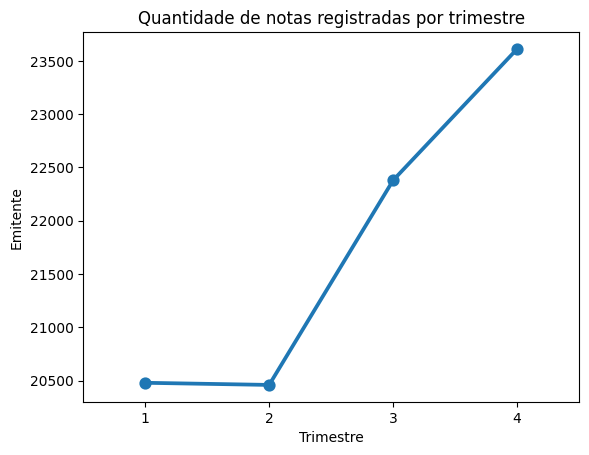

<ipython-input-9-2537541ef63b>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tempo = df.groupby(['Trimestre', 'categoria'])['Emitente'].count().reset_index()  # Contando 'Emitente' para cada categoria


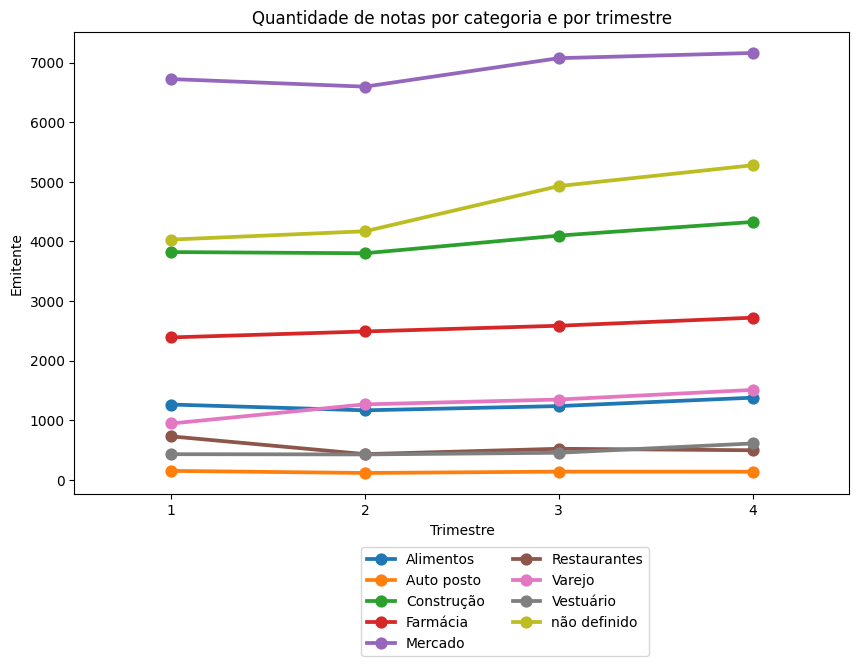

<ipython-input-9-2537541ef63b>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tempo = df.query('Retorno > 0').groupby(['Trimestre', 'categoria'])['Retorno'].sum().reset_index()


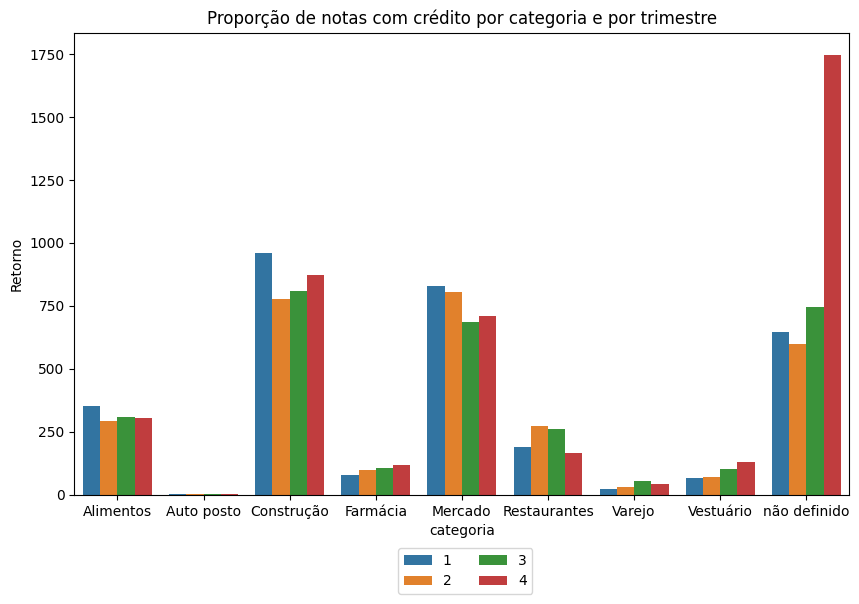

In [9]:

# Gráfico da quantidade de notas registradas na base por período
df_tempo = df.groupby(['Trimestre'])['Emitente'].count().reset_index()  # Contando a coluna 'Emitente'

fig, ax = plt.subplots()
sns.pointplot(data=df_tempo, x='Trimestre', y='Emitente', ax=ax)
ax.set_title("Quantidade de notas registradas por trimestre")
plt.show()

# Gráfico da quantidade de notas por categoria e por período
df_tempo = df.groupby(['Trimestre', 'categoria'])['Emitente'].count().reset_index()  # Contando 'Emitente' para cada categoria

fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(data=df_tempo, x='Trimestre', y='Emitente', hue='categoria', ax=ax)
ax.legend(bbox_to_anchor=(0.75, -0.1), ncol=2)
ax.set_title("Quantidade de notas por categoria e por trimestre")
plt.show()

# Gráfico da proporção de notas com crédito por categoria por período
df_tempo = df.query('Retorno > 0').groupby(['Trimestre', 'categoria'])['Retorno'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_tempo, x='categoria', y='Retorno', hue='Trimestre', ax=ax)
ax.legend(bbox_to_anchor=(0.6, -0.1), ncol=2)
ax.set_title("Proporção de notas com crédito por categoria e por trimestre")
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [10]:
df_tempo = df.copy()
df_tempo['Data Registro'] = df_tempo['Data Registro'].dt.to_period('M')
df_tempo = df_tempo.groupby(['Data Registro', 'categoria', 'evento'])['evento'].count()
df_tempo = df_tempo.to_frame()
df_tempo

evento
Data Registro categoria    evento        
2020-01       Alimentos    False       51
                           True       215
              Auto posto   False       28
                           True        11
              Construção   False      299
...                                   ...
2021-12       não definido False      663
                           True       346
2022-02       não definido True         1
2022-03       não definido True         1
2022-04       Restaurantes False        1

[435 rows x 1 columns]

In [11]:
tab = df_tempo.unstack()['evento']
tab['N'] = tab.sum(axis=1)

tab['tx_evento'] = tab[True]/tab.N
tab.reset_index()
tab.head()

evento                    False   True       N  tx_evento
Data Registro categoria                                  
2020-01       Alimentos    51.0  215.0   266.0   0.808271
              Auto posto   28.0   11.0    39.0   0.282051
              Construção  299.0  333.0   632.0   0.526899
              Farmácia    281.0   61.0   342.0   0.178363
              Mercado     532.0  474.0  1006.0   0.471173

In [12]:
rotulo_ev, rotulo_nev = (True, False)

tab['pct_evento']     = tab[rotulo_ev]/tab[rotulo_ev].groupby(level=0).sum()
tab['pct_nao_evento'] = tab[rotulo_nev]/tab[rotulo_nev].groupby(level=0).sum()
tab['WOE'] = np.log(tab.pct_evento/tab.pct_nao_evento)
tab

evento                      False   True       N  tx_evento  pct_evento  \
Data Registro categoria                                                   
2020-01       Alimentos      51.0  215.0   266.0   0.808271    0.129518   
              Auto posto     28.0   11.0    39.0   0.282051    0.006627   
              Construção    299.0  333.0   632.0   0.526899    0.200602   
              Farmácia      281.0   61.0   342.0   0.178363    0.036747   
              Mercado       532.0  474.0  1006.0   0.471173    0.285542   
...                           ...    ...     ...        ...         ...   
2021-12       Vestuário     110.0   28.0   138.0   0.202899    0.015722   
              não definido  663.0  346.0  1009.0   0.342914    0.194273   
2022-02       não definido    NaN    1.0     1.0   1.000000    1.000000   
2022-03       não definido    NaN    1.0     1.0   1.000000    1.000000   
2022-04       Restaurantes    1.0    NaN     1.0        NaN         NaN   

evento                      pct_nao_evento       WOE  
Data Registro categoria                               
2020-01       Alimentos           0.029859  1.467318  
              Auto posto          0.016393 -0.905804  
              Construção          0.175059  0.136204  
              Farmácia            0.164520 -1.498975  
              Mercado             0.311475 -0.086931  
...                                    ...       ...  
2021-12       Vestuário           0.044607 -1.042853  
              não definido        0.268856 -0.324914  
2022-02       não definido             NaN       NaN  
2022-03       não definido             NaN       NaN  
2022-04       Restaurantes        1.000000       NaN  

[219 rows x 7 columns]

<ipython-input-13-7dfb4b8aa3ac>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labs,rotation=30, fontsize='small')


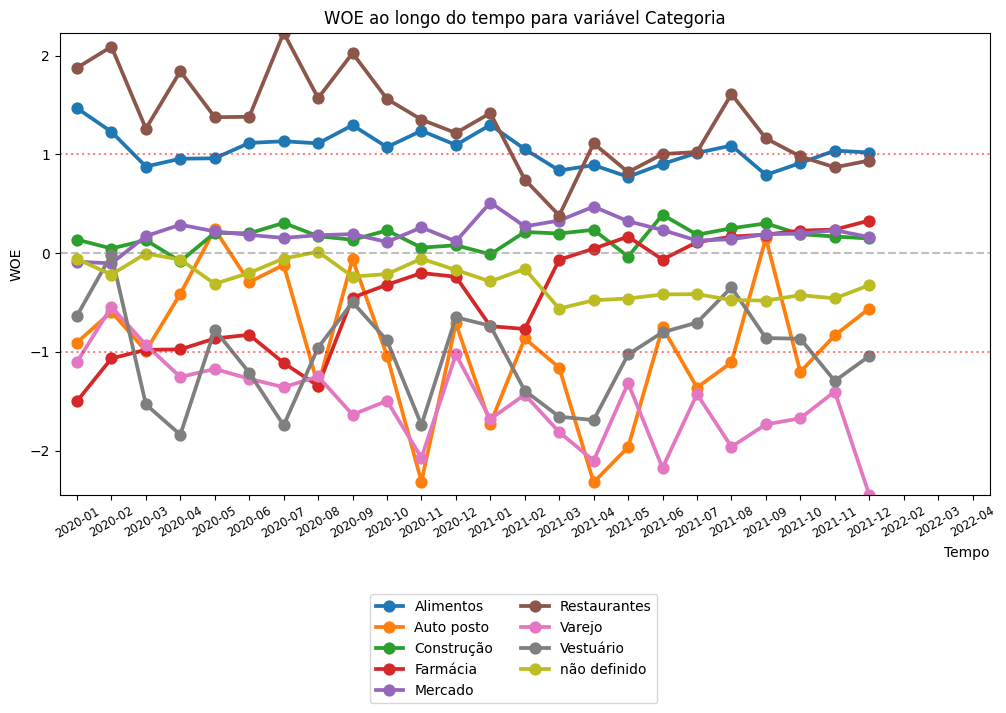

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
variavel='categoria'

# Comando principal do gráfico
sns.pointplot(data=tab.reset_index(), y = 'WOE', x = 'Data Registro', hue=variavel, ax=ax);

# ax.legend(bbox_to_anchor=(.6, -.1), ncol=2)

# Rotacionar os rótulos do eixo X
labs = tab.index.get_level_values(level=0).unique()
# labs2 = [x.to_period('M') for x in labs]

ax.set_xticklabels(labs,rotation=30, fontsize='small')
ax.legend(bbox_to_anchor=(.65, -.2), ncol=2)

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(1.2, max(tab.WOE))
ymin = min(-1.2, min(tab.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo do tempo para variável {variavel.capitalize()}')
ax.set_xlabel('Tempo', loc='right');

<Axes: xlabel='Data Registro'>

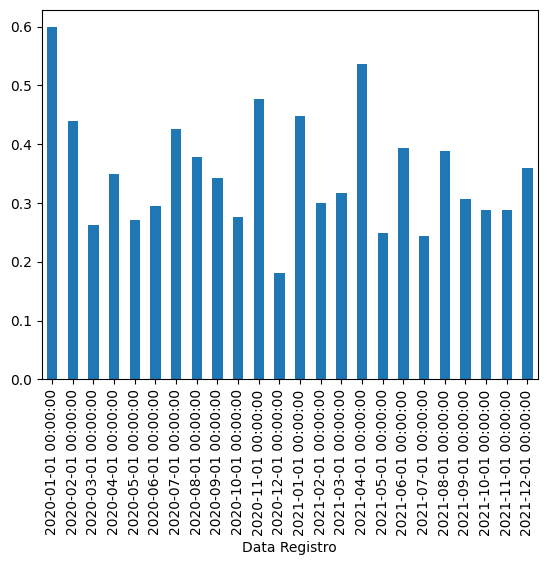

In [14]:
iv_categoria = ((tab.pct_evento - tab.pct_nao_evento)*tab.WOE).groupby(level=0).sum();
iv_categoria = iv_categoria[iv_categoria>0]
iv_categoria.index = iv_categoria.index.to_timestamp()
iv_categoria.plot.bar()

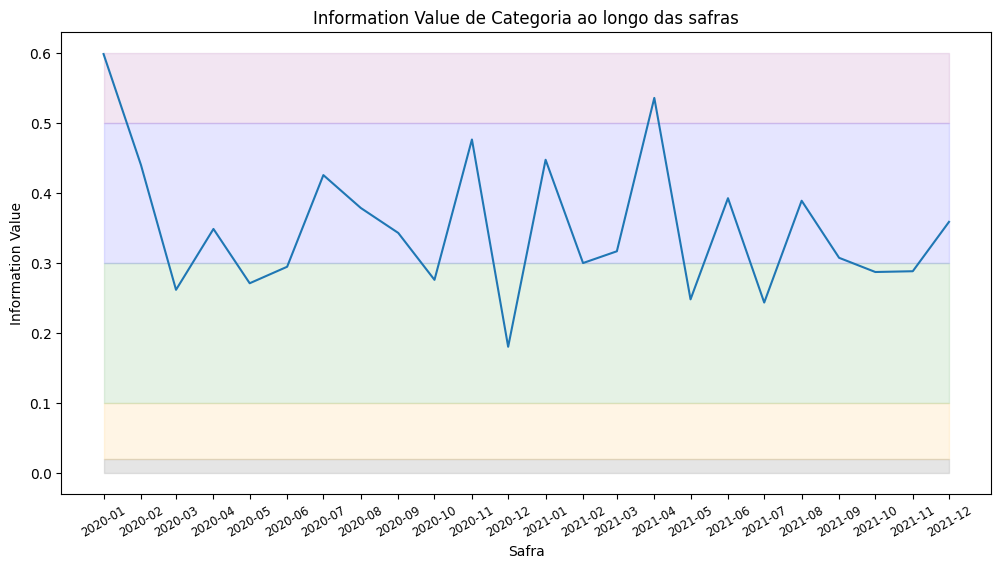

In [15]:
def plot_iv(IV):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    labs = IV.index.get_level_values(level=0).unique()
    labs2 = [x.to_period('M') for x in labs]

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de Categoria ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")

plot_iv(iv_categoria)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.



1.   As categorias com maior proporção de notas com retornos maiores que zero são **Vestuário**, **Restaurantes** e **Construção**. Essas categorias apresentam, de forma consistente, uma proporção superior de retornos positivos em comparação com outras.

2.  O gráfico de WOE ao longo do tempo demonstra que as variáveis não são estáveis no tempo, muitas vezes se cruzando e mudando de importância.

